In [1]:
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
import requests
import os
import io
import zipfile
import json
import requests
import urllib.request
import pandas as pd

# 地理空間情報の取得(可視化用)

In [2]:
def save_shp(url:str, index:int|str)->gpd.GeoDataFrame():
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as res:
        data = res.read()
    path = os.path.join(os.getcwd(), 'sources')
    os.makedirs(path, exist_ok=True)
    # データがzipファイルになっているので中身を抽出して変数に格納する
    with zipfile.ZipFile(io.BytesIO(data), 'r') as zip_data:
        zip_data.extractall(path)

In [3]:
# save_shp('https://www/.esrij.com/cgi-bin/wp/wp-content/uploads/2012/10/japan_ver84.zip', 0)
gdf = gpd.read_file(os.path.join(os.getcwd(), 'sources','japan_ver84/japan_ver84.shp'))
gdf_KEN = gdf.dissolve('KEN').query('KEN in ["茨城県","埼玉県", "千葉県", "東京都", "神奈川県"]')

# 相模原市はH22年に政令指定都市になったため統合
gdf_sagami = gdf.query('JCODE in ["14151","14152","14153"]').dissolve(by='SEIREI',aggfunc='sum')
gdf_sagami['JCODE'] = '14150'
gdf_sagami['KEN'] = '神奈川県'

gdf = gdf.query('JCODE not in ["14151","14152","14153"]')
gdf = gdf.query('KEN in ["茨城県", "埼玉県", "千葉県", "東京都", "神奈川県", "山梨県"]')
gdf_all = pd.concat([gdf, gdf_sagami]).sort_values('JCODE').reset_index()
gdf_all['P_DENS'] = gdf_all['P_NUM'] / (gdf_all['Shape_Area']*10000)

# gdf = gdf_all.query('SIKUCHOSON.str.contains("区") | P_NUM>150000', engine='python')
# 人口密度
gdf = gdf_all.query('P_DENS > 4000')
gdf = gdf.query('KEN not in ["茨城県","山梨県"]')
jcode = gdf.JCODE.to_list()
From = '11000'
To = '15000'

In [4]:
gdf_KEN = gpd.read_file(os.path.join(os.getcwd(), 'sources','japan_ver84/japan_ver84.shp'))
gdf_KEN = gdf_KEN.dissolve('KEN').query('KEN in ["茨城県","埼玉県", "千葉県", "東京都", "神奈川県"]')

import matplotlib.pyplot as plt


In [5]:
def plot_gdf(given_gdf):
    fig = given_gdf.plot(
        legend=True,
        figsize=(8, 10),
        linewidth=1,
        # cmap=plt.cm.Blues,
        legend_kwds={'shrink': 0.65, 'format':format},
        missing_kwds={'color': 'white',"hatch": "///","edgecolor": "black"}
    )
    fig = gdf_KEN.plot(ax=fig, color=(0,0,0,0), edgecolor='black')
    clb = fig.get_figure().axes[-1]
    # plt.text(140.35, 35.2, unit, horizontalalignment='right',verticalalignment='bottom')
    fig.set_xlim(139.2, 140.2)
    fig.set_ylim(35.2, 36.05)

111


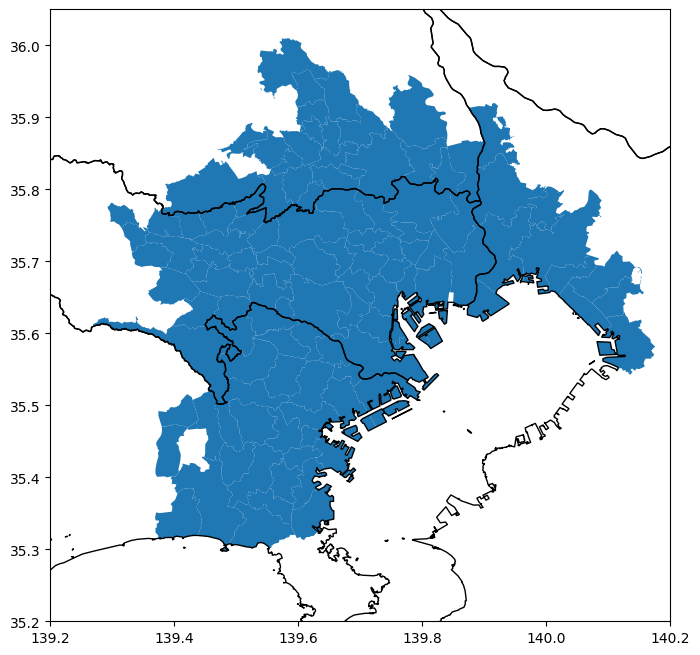

In [6]:
print(len(gdf))
plot_gdf(gdf)

# 地価情報の取得

In [7]:
# pd.read_excel('https://www.mlit.go.jp/totikensangyo/content/001733704.xls')
df = pd.read_excel('/Users/nagampere/File/horkew/analysis/master_thesis/sources/001733704.xls')
nayose = pd.read_csv('/Users/nagampere/File/horkew/analysis/master_thesis/sources/chika_nayose.csv')

In [8]:
df_all = pd.merge(nayose, 
                  df.loc[nayose['住宅'],['令和2年']].fillna(0).astype({'令和2年':int}).reset_index(),
                  left_on='住宅', right_on='index',how='left')
df_all = pd.merge(df_all,
                  df.loc[nayose['商業'],['令和2年']].fillna(0).astype({'令和2年':int}).reset_index(),
                  left_on='商業', right_on='index',how='left')
df_all = df_all.drop(columns=['index_x','index_y'])
df_all = df_all.rename(columns={'令和2年_x':'res_price','令和2年_y':'com_price'})
df_all = df_all.query('res_price!=0 & com_price!=0')

In [9]:
df_all['jcode'] = df_all['JCODE'].astype(str)
df_all = df_all[df_all['jcode'].isin(jcode)].sort_values('JCODE').reset_index()

In [10]:
# 2020年居住地平均価格を参考に、300,000円/坪で正規化
print('居住地価格平均値:', np.mean(df_all['res_price'].to_numpy()))
print('居住地価格中央値:', np.median(df_all['res_price'].to_numpy()))

居住地価格平均値: 341795.4954954955
居住地価格中央値: 233400.0


In [11]:
df_all['q_i'] = df_all['res_price']/300000
df_all['Q_j'] = df_all['com_price']/300000
print(df_all['q_i'].mean())
print(df_all['Q_j'].mean())

1.1393183183183182
2.9033813813813807


In [12]:
df_q_i = df_all[['jcode','q_i']].round(6)
df_Q_j = df_all[['jcode','Q_j']].round(6)

In [13]:
df_all.sort_values('JCODE')

,index,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CHIKA,住宅,商業,res_price,com_price,jcode,q_i,Q_j
0,1,11102,埼玉県,NaN,NaN,さいたま市,北区,北区,9858,9862,174900,329700,11102,0.583000,1.099000
1,2,11103,埼玉県,NaN,NaN,さいたま市,大宮区,大宮区,9872,9876,262300,1055900,11103,0.874333,3.519667
2,3,11104,埼玉県,NaN,NaN,さいたま市,見沼区,見沼区,9886,9890,113600,171300,11104,0.378667,0.571000
3,4,11105,埼玉県,NaN,NaN,さいたま市,中央区,中央区,9900,9904,269800,418700,11105,0.899333,1.395667
4,5,11106,埼玉県,NaN,NaN,さいたま市,桜区,桜区,9914,9918,162300,170000,11106,0.541000,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,168,14205,神奈川県,NaN,NaN,NaN,藤沢市,藤沢市,13988,13992,188400,409800,14205,0.628000,1.366000
107,170,14207,神奈川県,NaN,NaN,NaN,茅ヶ崎市,茅ケ崎市,14016,14020,192300,302200,14207,0.641000,1.007333
108,175,14213,神奈川県,NaN,NaN,NaN,大和市,大和市,14086,14090,187500,318800,14213,0.625000,1.062667
109,177,14215,神奈川県,NaN,NaN,NaN,海老名市,海老名市,14114,14118,155900,431300,14215,0.519667,1.437667


# 所得w_jの取得

In [5]:
# 所得w_jの取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
    'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
    'lang':'J',
    'statsDataId':'0003355997',
    # 'metaGetFlg':'N',
    'explanationGetFlg':'N',
    'annotationGetFlg':'N',
    'cdTab':'13-2018',
    'cdCat01':'0',
    'cdCat02':'0',
    # 'lvArea':'2-',
    'cdAreaFrom': '11000',
    'cdAreaTo': '15000',
}

In [6]:
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 家計を主に支える者と住居 世帯の年間収入階級(9区分)，世帯の種類(2区分)，住宅の所有の関係(5区分)別普通世帯数，１世帯当たり人員，１世帯当たり居住室数及び１世帯当たり居住室の畳数－全国，都道府県，市区町村
ヒット件数： 2220


[{'@id': 'tab',
  '@name': '表章項目',
  'CLASS': {'@code': '13-2018',
   '@name': '普通世帯数',
   '@level': '',
   '@unit': '世帯'}},
 {'@id': 'cat01',
  '@name': '世帯の種類',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '住宅の所有の関係',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '世帯の年間収入階級',
  'CLASS': [{'@code': '00', '@name': '総数', '@level': '1'},
   {'@code': '01', '@name': '100万円未満', '@level': '1'},
   {'@code': '02', '@name': '100～200万円未満', '@level': '1'},
   {'@code': '04', '@name': '200～300万円未満', '@level': '1'},
   {'@code': '05', '@name': '300～400万円未満', '@level': '1'},
   {'@code': '06', '@name': '400～500万円未満', '@level': '1'},
   {'@code': '07', '@name': '500～700万円未満', '@level': '1'},
   {'@code': '08', '@name': '700～1000万円未満', '@level': '1'},
   {'@code': '09', '@name': '1000～1500万円未満', '@level': '1'},
   {'@code': '10', '@name': '1500万円以上', '@level': '1'}]},
 {'@id': 'area',
  '@name': '地域',
  'CLASS': [{'@c

In [9]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

def parse_wage(x):
   if   x=='01': return 50
   elif x=='02': return 150
   elif x=='04': return 250
   elif x=='05': return 350
   elif x=='06': return 450
   elif x=='07': return 600
   elif x=='08': return 850
   elif x=='09': return 1250
   elif x=='10': return 2000
   else: return 0

df['weight'] = df['@cat03'].apply(parse_wage)
df['num'] = df['$'].astype(int)
df['jcode'] = df['@area']


wm = lambda x: np.average(x, weights=df.loc[x.index, "num"]).round(2)
df_w_j = df.groupby(by='jcode').agg(w_j=("weight", wm)).loc[jcode]
df_w_j = (df_w_j/df_w_j.mean()).round(6)
df_w_j

,w_j
jcode,
11102,1.043595
11103,1.085148
11104,0.943091
11105,1.063373
11106,0.827533
...,...
14205,1.016520
14207,0.964367
14213,0.915671


# 通勤割合λ_ijの取得

In [19]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003454528',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'0',
     # 'cdArea':','.join(list),
     # # 'cdCat02':','.join(list)
     # 'lvArea':'4-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdCat02From':From,
     'cdCat02To':To,
     }


In [20]:
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 人口 従業・通学市区町村，男女別通勤者数（15歳以上） － 全国，都道府県，市区町村（常住地）
ヒット件数： 68644


[{'@id': 'tab',
  '@name': '表章事項',
  'CLASS': {'@code': '2020_08', '@name': '通勤者数', '@level': '', '@unit': '人'}},
 {'@id': 'cat01',
  '@name': '男女',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '全国［総数］，都道府県，市区町村（従業地・通学地）',
  'CLASS': [{'@code': '11000',
    '@name': '埼玉県',
    '@level': '2',
    '@parentCode': '00000'},
   {'@code': '11100', '@name': 'さいたま市', '@level': '4', '@parentCode': '11000'},
   {'@code': '11101',
    '@name': 'さいたま市西区',
    '@level': '5',
    '@parentCode': '11100'},
   {'@code': '11102',
    '@name': 'さいたま市北区',
    '@level': '5',
    '@parentCode': '11100'},
   {'@code': '11103',
    '@name': 'さいたま市大宮区',
    '@level': '5',
    '@parentCode': '11100'},
   {'@code': '11104',
    '@name': 'さいたま市見沼区',
    '@level': '5',
    '@parentCode': '11100'},
   {'@code': '11105',
    '@name': 'さいたま市中央区',
    '@level': '5',
    '@parentCode': '11100'},
   {'@code': '11106',
    '@name': 'さいたま市桜区',
    '@level': '5',
    '@parentCode':

In [21]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_commute_ij = pd.DataFrame(0,columns=jcode,index=jcode)
for i in df.itertuples():
    if (i[3] not in jcode)|(i[4] not in jcode): continue
    if i[7] in ['-',None]: 
        df_commute_ij.at[i[4],i[3]]=0
    else: 
        if int(i[7]) > 100: df_commute_ij.at[i[4],i[3]]=int(i[7])

In [22]:
df_commute_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,19280,4582,1169,1676,378,1788,504,283,894,162,...,0,0,0,0,0,0,0,0,0,0
11103,1716,14645,946,1976,398,1653,430,311,773,108,...,0,0,0,0,0,0,0,0,0,0
11104,2619,4938,18079,1550,445,1968,623,1005,1517,125,...,0,0,0,0,0,0,0,0,0,0
11105,741,2696,365,10738,1123,2558,768,314,868,160,...,0,0,0,0,0,0,0,0,0,0
11106,384,1369,213,2001,11323,1905,1564,323,1035,233,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0,0,0,0,0,0,0,0,0,0,...,326,224,157,350,8978,75307,4972,3498,1748,686
14207,0,0,0,0,0,0,0,0,0,0,...,117,0,0,0,2223,11845,31932,562,986,258
14213,0,0,0,0,0,0,0,0,0,0,...,575,255,415,478,423,4326,298,28309,2013,3377
14215,0,0,0,0,0,0,0,0,0,0,...,109,150,0,246,128,1473,446,1897,16821,2122


In [23]:
df_Pi_ij = (df_commute_ij/np.sum(df_commute_ij.to_numpy())).round(9)
df_Pi_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0.002054,0.000488,0.000125,0.000179,0.000040,0.000190,0.000054,0.000030,0.000095,0.000017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11103,0.000183,0.001560,0.000101,0.000210,0.000042,0.000176,0.000046,0.000033,0.000082,0.000012,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11104,0.000279,0.000526,0.001926,0.000165,0.000047,0.000210,0.000066,0.000107,0.000162,0.000013,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11105,0.000079,0.000287,0.000039,0.001144,0.000120,0.000272,0.000082,0.000033,0.000092,0.000017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11106,0.000041,0.000146,0.000023,0.000213,0.001206,0.000203,0.000167,0.000034,0.000110,0.000025,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000035,0.000024,0.000017,0.000037,0.000956,0.008022,0.000530,0.000373,0.000186,0.000073
14207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000012,0.000000,0.000000,0.000000,0.000237,0.001262,0.003402,0.000060,0.000105,0.000027
14213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000061,0.000027,0.000044,0.000051,0.000045,0.000461,0.000032,0.003016,0.000214,0.000360
14215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000012,0.000016,0.000000,0.000026,0.000014,0.000157,0.000048,0.000202,0.001792,0.000226


# 世帯あたり子供の数n_ijの取得

In [24]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003445162',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'0',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     'cdCat02' :'0',
     'cdCat03' :'01,02,03'
     }

In [25]:
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 総人口・総世帯数・男女・年齢・配偶関係 男女，年齢（5歳階級），国籍総数か日本人別人口－全国，都道府県，市区町村（2000年（平成12年）市区町村含む）
ヒット件数： 1068


[{'@id': 'tab',
  '@name': '表章事項',
  'CLASS': {'@code': '2020_01', '@name': '人口', '@level': '', '@unit': '人'}},
 {'@id': 'cat01',
  '@name': '国籍総数か日本人',
  'CLASS': {'@code': '0', '@name': '国籍総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '男女',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '年齢',
  'CLASS': [{'@code': '01', '@name': '0～4歳', '@level': '1'},
   {'@code': '02', '@name': '5～9歳', '@level': '1'},
   {'@code': '03', '@name': '10～14歳', '@level': '1'}]},
 {'@id': 'area',
  '@name': '全国，都道府県，市区町村（2000年市区町村含む）',
  'CLASS': [{'@code': '11000',
    '@name': '埼玉県',
    '@level': '2',
    '@parentCode': '00000'},
   {'@code': '11100', '@name': 'さいたま市', '@level': '4', '@parentCode': '11000'},
   {'@code': '11204',
    '@name': '（旧：浦和市）',
    '@level': '7',
    '@parentCode': '11000'},
   {'@code': '11205',
    '@name': '（旧：大宮市）',
    '@level': '7',
    '@parentCode': '11000'},
   {'@code': '11213',
    '@name': '（旧：岩槻市）',
    '@level': '7',
 

In [26]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_children_i = pd.DataFrame(0,index=jcode,columns=[0])
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: df_children_i.at[i[5],0] += int(i[8])
    except: pass

In [27]:
arr_children_ij = df_children_i.to_numpy() * df_commute_ij.to_numpy()/df_commute_ij.sum(axis=1).to_numpy().reshape(1,-1).T
df_children_ij = pd.DataFrame(arr_children_ij,index=jcode, columns=jcode)
df_children_ij = (df_children_ij/df_commute_ij).fillna(0)

In [28]:
df_children_ij

,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
11102,0.366195,0.366195,0.366195,0.366195,0.366195,0.366195,0.366195,0.366195,0.366195,0.366195,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11103,0.352062,0.352062,0.352062,0.352062,0.352062,0.352062,0.352062,0.352062,0.352062,0.352062,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11104,0.395356,0.395356,0.395356,0.395356,0.395356,0.395356,0.395356,0.395356,0.395356,0.395356,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11105,0.345816,0.345816,0.345816,0.345816,0.345816,0.345816,0.345816,0.345816,0.345816,0.345816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11106,0.315933,0.315933,0.315933,0.315933,0.315933,0.315933,0.315933,0.315933,0.315933,0.315933,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.363686,0.363686,0.363686,0.363686,0.363686,0.363686,0.363686,0.363686,0.363686,0.363686
14207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.411279,0.000000,0.000000,0.000000,0.411279,0.411279,0.411279,0.411279,0.411279,0.411279
14213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.378009,0.378009,0.378009,0.378009,0.378009,0.378009,0.378009,0.378009,0.378009,0.378009
14215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.470194,0.470194,0.000000,0.470194,0.470194,0.470194,0.470194,0.470194,0.470194,0.470194


# 交通費用の算出

In [29]:
gdf_11 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_11_GML.zip',encoding='CP932')
gdf_12 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_12_GML.zip',encoding='CP932')
gdf_13 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_13_GML.zip',encoding='CP932')
gdf_14 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_14_GML.zip',encoding='CP932')
gdf_gov = pd.concat([gdf_11,gdf_12,gdf_13,gdf_14])
gdf_gov = gdf_gov[gdf_gov['P34_001'].isin(jcode)]
gdf_gov = gdf_gov[gdf_gov['P34_002']=='1'].sort_values('P34_001').reset_index(drop=True)

gdf_gov = gdf_gov.to_crs(epsg=4326)
def to_str(x):
    x = str(x)
    if len(x) == 1: x = '000'+x
    elif len(x) == 2: x = '00'+x
    elif len(x) == 3: x = '0'+x
    return x
gdf_PTzone = gpd.read_file('sources/H30_kzone_4326.geojson')
gdf_PTzone['kzone'] = gdf_PTzone['kzone'].apply(to_str)

gdf_gov = gdf_gov.sjoin(gdf_PTzone, how='left')

In [30]:
df_time = pd.read_excel('sources/e-2_H30.xlsx', skiprows=[0,1,2])
df_time['発ゾーン'] = df_time['発ゾーン'].str.strip(':')
df_time['着ゾーン'] = df_time['着ゾーン'].str.strip(':')
ptcode = gdf_gov['kzone'].tolist()
df_time = df_time[(df_time['発ゾーン'].isin(ptcode))&(df_time['着ゾーン'].isin(ptcode))]

In [31]:
df_time = df_time.merge(gdf_gov[['P34_001','kzone']], left_on='発ゾーン', right_on='kzone', how='left').rename(columns={'P34_001':'ori_jcode'}).drop(columns='kzone')
df_time = df_time.merge(gdf_gov[['P34_001','kzone']], left_on='着ゾーン', right_on='kzone', how='left').rename(columns={'P34_001':'dst_jcode'}).drop(columns='kzone')

df_time = df_time.sort_values(['ori_jcode', 'dst_jcode'])
df_time['鉄道'] = df_time['鉄道'].where(df_time['鉄道'] !=0.0, df_time[['バス','自動車']].apply(lambda x: np.round(np.mean(x),2), axis=1))

In [32]:
df_time_ij = (df_time.pivot_table(values='鉄道', index='ori_jcode', columns='dst_jcode', fill_value=df_time['鉄道'].max())/(60*24)).round(6)

In [33]:
df_time_ij

dst_jcode,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
11102,0.011729,0.023792,0.023000,0.023042,0.052083,0.027868,0.041201,0.041278,0.052083,0.187500,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
11103,0.017049,0.020833,0.025417,0.019729,0.042049,0.023403,0.032500,0.032444,0.041667,0.059028,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.083333,0.187500,0.187500,0.187500
11104,0.017361,0.025319,0.014160,0.024111,0.031250,0.031847,0.031250,0.051014,0.038194,0.076389,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
11105,0.022465,0.015778,0.031424,0.019208,0.028785,0.017938,0.029979,0.038389,0.033139,0.062500,...,0.187500,0.076389,0.072917,0.187500,0.187500,0.187500,0.128472,0.187500,0.090278,0.187500
11106,0.052083,0.028972,0.031250,0.034479,0.013889,0.027778,0.028333,0.033028,0.187500,0.055556,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.090278,...,0.187500,0.036444,0.047951,0.187500,0.031424,0.019924,0.031639,0.032951,0.040833,0.048611
14207,0.187500,0.187500,0.187500,0.096528,0.187500,0.094444,0.187500,0.187500,0.187500,0.187500,...,0.076389,0.187500,0.187500,0.187500,0.040111,0.031451,0.019722,0.053465,0.043979,0.055556
14213,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.041667,0.187500,0.187500,0.187500,...,0.041667,0.045000,0.030097,0.041632,0.051389,0.031167,0.051215,0.024278,0.035611,0.039951


In [34]:
df_time_ij_sim = df_time_ij
df_time_ij_sim.loc['13101':'13123',:] = df_time_ij_sim.loc['13101':'13123',:]*0.50
df_time_ij_sim.loc[:,'13101':'13123'] = df_time_ij_sim.loc[:,'13101':'13123']*0.50
df_time_ij_sim.loc['13101':'13123','13101':'13123'] = df_time_ij_sim.loc['13101':'13123','13101':'13123']/0.50
df_time_ij_sim

dst_jcode,11102,11103,11104,11105,11106,11107,11108,11109,11203,11208,...,14134,14135,14136,14137,14204,14205,14207,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
11102,0.011729,0.023792,0.023000,0.023042,0.052083,0.027868,0.041201,0.041278,0.052083,0.187500,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
11103,0.017049,0.020833,0.025417,0.019729,0.042049,0.023403,0.032500,0.032444,0.041667,0.059028,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.083333,0.187500,0.187500,0.187500
11104,0.017361,0.025319,0.014160,0.024111,0.031250,0.031847,0.031250,0.051014,0.038194,0.076389,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
11105,0.022465,0.015778,0.031424,0.019208,0.028785,0.017938,0.029979,0.038389,0.033139,0.062500,...,0.187500,0.076389,0.072917,0.187500,0.187500,0.187500,0.128472,0.187500,0.090278,0.187500
11106,0.052083,0.028972,0.031250,0.034479,0.013889,0.027778,0.028333,0.033028,0.187500,0.055556,...,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.090278,...,0.187500,0.036444,0.047951,0.187500,0.031424,0.019924,0.031639,0.032951,0.040833,0.048611
14207,0.187500,0.187500,0.187500,0.096528,0.187500,0.094444,0.187500,0.187500,0.187500,0.187500,...,0.076389,0.187500,0.187500,0.187500,0.040111,0.031451,0.019722,0.053465,0.043979,0.055556
14213,0.187500,0.187500,0.187500,0.187500,0.187500,0.187500,0.041667,0.187500,0.187500,0.187500,...,0.041667,0.045000,0.030097,0.041632,0.051389,0.031167,0.051215,0.024278,0.035611,0.039951


運賃の参考
初乗り:　150円
https://www.jreast.co.jp/press/2019/20190702.pdf
距離運賃: 17.8円/km
https://www.jreast.co.jp/ryokaku/02_hen/03_syo/02_setsu/04.html

In [35]:
gdf_gov = gdf_gov.to_crs(epsg=6677)
distance_matrix = gdf_gov.geometry.apply(lambda x: gdf_gov.distance(x)).values
distance_matrix = np.where(distance_matrix/1000 > 140/16.8, distance_matrix/1000*16.8, 140)
distance_matrix = distance_matrix / np.mean(distance_matrix) / 20
distance_matrix = np.round(distance_matrix, 5)
df_cost_ij = pd.DataFrame(distance_matrix,index=jcode, columns=jcode)

In [36]:
df

,@tab,@cat01,@cat02,@cat03,@area,@time,@unit,$
0,2020_01,0,0,01,11000,2020000000,人,259281
1,2020_01,0,0,01,11100,2020000000,人,53391
2,2020_01,0,0,01,11204,2020000000,人,25417
3,2020_01,0,0,01,11205,2020000000,人,20124
4,2020_01,0,0,01,11213,2020000000,人,3845
...,...,...,...,...,...,...,...,...
1063,2020_01,0,0,03,14383,2020000000,人,179
1064,2020_01,0,0,03,14384,2020000000,人,755
1065,2020_01,0,0,03,14401,2020000000,人,1701
1066,2020_01,0,0,03,14402,2020000000,人,124


# 土地賦存量

In [37]:
df_land = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031956084&fileKind=0', skiprows=[0,1,2,3,4,6,7,8,9], index_col='市区町村')

In [38]:
df_land['jcode'] = df_land['市区\n町村\nｺｰﾄﾞ'].astype(str)
df_land['K_i'] = df_land['可住地面積']*1000*1000
df_land = df_land[df_land['jcode'].isin(jcode)].reset_index()

In [39]:
df_land = df_land[['jcode','K_i']].round(0)
df_land

,jcode,K_i
0,11102,16850000.0
1,11103,12760000.0
2,11104,29700000.0
3,11105,8390000.0
4,11106,18310000.0
...,...,...
106,14205,63800000.0
107,14207,32720000.0
108,14213,25880000.0
109,14215,26080000.0


# 商業地比率の算出

データは建築着工統計調査から取得
https://www.e-stat.go.jp/stat-search/files?tclass=000001011993&cycle=7&year=20200

In [40]:
# 左の列が床面積・右の列が棟数
df_area = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000032048038&fileKind=0', skiprows=[0,1,2,3,5,6], index_col=0, usecols=[0,1,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40])
columns = {
    '用途　　　　(大分類)': 'jcode_name',
    'Unnamed: 4': '全建築物計' ,
    'Unnamed: 6': 'A居住専用住宅',
    'Unnamed: 8': 'B居住専用準住宅',
    'Unnamed: 10': 'C居住産業併用建築物',
    'Unnamed: 12': 'D農林水産業用建築物',
    'Unnamed: 14': 'E鉱業，採石業，砂利採取業，建設業用建築物',
    'Unnamed: 16': 'F製造業用建築物',
    'Unnamed: 18': 'G電気・ガス・熱供給・水道業用建築物',
    'Unnamed: 20': 'H情報通信業用建築物',
    'Unnamed: 22': 'I運輸業用建築物',
    'Unnamed: 24': 'J卸売業，小売業用建築物',
    'Unnamed: 26': 'K金融業，保険業用建築物',
    'Unnamed: 28': 'L不動産業用建築物',
    'Unnamed: 30': 'M宿泊業，飲食サービス業用建築物',
    'Unnamed: 32': 'N教育，学習支援業用建築物',
    'Unnamed: 34': 'O医療，福祉用建築物',
    'Unnamed: 36': 'Pその他のサービス業用建築物',
    'Unnamed: 38': 'Q公務用建築物',
    'Unnamed: 40': 'R他に分類されない建築物'
}
df_area = df_area.rename(columns=columns).fillna(0)
df_area = df_area.reset_index(drop=True)
df_area['jcode'] = df_area['jcode_name'].str.extract(r'^(.{5})')


In [41]:
df_area['res_area'] = df_area[[
    'A居住専用住宅',
    'B居住専用準住宅',
    'C居住産業併用建築物'
]].apply(lambda x: np.sum(x), axis=1)

df_area['com_area'] = df_area[[
    'D農林水産業用建築物',
    'E鉱業，採石業，砂利採取業，建設業用建築物',
    'F製造業用建築物',
    'G電気・ガス・熱供給・水道業用建築物',
    'H情報通信業用建築物',
    'I運輸業用建築物',
    'J卸売業，小売業用建築物',
    'K金融業，保険業用建築物',
    'L不動産業用建築物',
    'M宿泊業，飲食サービス業用建築物',
    'N教育，学習支援業用建築物',
    'O医療，福祉用建築物',
    'Pその他のサービス業用建築物',
    'Q公務用建築物',
    'R他に分類されない建築物'
]].apply(lambda x: np.sum(x), axis=1)
df_area['theta_i'] = df_area['com_area'] / (df_area['com_area']+df_area['res_area'])
df_area = df_area[df_area['jcode'].isin(jcode)]

In [42]:
df_theta = df_area[['jcode','theta_i']].reset_index(drop=True).round(6)

住宅件数と事業所数から算出
- 令和3年延べ面積比率（区別）
  - https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_r3/tochi_r3_67.csv
- 事業所数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=A%2CB%2CC%2CD%2CE%2CF%2CG%2CH%2CI%2CJ%2CK%2CL%2CM%2CN%2CO%2CP%2CQ%2CR&cdTab=102-2021&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&appId=&lang=J&statsDataId=0004005684&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 
- 住宅数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=1%2C2%2C3%2C4&cdCat02=00&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&cdCat03=0&appId=&lang=J&statsDataId=0003355607&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 

In [43]:
# df_weight = pd.read_csv('https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_5/tochi_5list_67.csv', encoding='CP932')
df_weight = pd.read_csv('https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_r3/tochi_r3_61.csv', encoding='CP932')

In [44]:
df_weight

,地域,Area,BP-1／官公庁施設構成比(%),BP-2／教育文化施設構成比(%),BP-3／厚生医療施設構成比(%),BP-4／供給処理施設構成比(%),BC-1／事務所建築物構成比(%),BC-2／専用商業施設構成比(%),BC-3／住商併用施設構成比(%),BC-4／宿泊・遊興施設構成比(%),BC-5／スポーツ・興行施設構成比(%),BR-1／独立住宅構成比(%),BR-2／集合住宅構成比(%),BI-1／専用工場構成比(%),BI-2／住居併用工場構成比(%),BI-3／倉庫運輸関係施設構成比(%),BA／農林漁業施設構成比(%)
0,千代田区,Chiyoda-ku,8.6,12.2,1.1,0.2,50.1,5.2,4.3,3.4,0.4,1.6,9.5,0.1,0.2,3.3,-
1,中央区,Chuo-ku,2.5,3.3,1.4,1.6,44.2,6.0,8.5,3.3,0.1,3.5,21.9,0.2,0.4,3.1,-
2,港区,Minato-ku,3.0,9.2,1.9,1.3,28.7,4.5,4.8,4.9,0.8,7.9,27.8,0.4,0.4,4.3,-
3,新宿区,Shinjuku-ku,1.9,9.4,2.8,0.7,13.0,3.3,7.0,3.1,1.6,20.7,34.3,0.5,0.7,1.0,-
4,文京区,Bunkyo-ku,1.0,15.1,2.8,0.2,8.8,0.6,8.0,1.1,2.1,29.7,27.9,0.5,1.3,0.9,-
5,台東区,Taito-ku,0.9,11.0,1.5,0.5,14.7,4.3,15.2,3.7,0.2,18.8,21.3,0.6,4.0,3.1,-
6,墨田区,Sumida-ku,0.7,5.5,2.4,0.8,6.0,3.7,12.2,1.1,0.8,24.1,27.5,4.8,8.0,2.7,-
7,江東区,Koto-ku,1.4,5.6,1.6,5.1,9.1,7.3,5.3,1.0,2.4,12.2,23.3,3.7,1.7,20.3,-
8,品川区,Shinagawa-ku,1.1,5.8,1.4,1.5,8.8,2.7,6.4,0.8,1.2,26.6,32.7,2.4,1.9,6.7,0
9,目黒区,Meguro-ku,0.8,6.9,2.0,0.0,3.5,2.2,7.3,0.7,0.5,39.3,34.8,0.5,0.9,0.7,0


A農業、林業: なし

B漁業: なし

C鉱業、採石業、砂利採取業: なし

D建設業: なし

E製造業: BI-1, BI-2

F電気・ガス・熱供給・水道業 : BP-4

G情報通信業: BC-1

H運輸業、郵便業: BI-3

I卸売業、小売業: BC-2, BC-3, BC-4, BC-5

J金融業、保険業: BC-1

K不動産業、物品賃貸業: BC-1

L学術研究、専門・技術サービス業: BC-1

M宿泊業、飲食サービス業: BC-2, BC-3, BC-4, BC-5

N生活関連サービス業、娯楽業: BC-2, BC-3, BC-4, BC-5

O教育、学習支援業: BP-2

P医療、福祉: BP-3

Q複合サービス事業: BC-2, BC-3, BC-4, BC-5

Rサービス業（他に分類されないもの）: BC-2, BC-3, BC-4, BC-5

＊S公務（他に分類されるものを除く）: BP-1

In [45]:
df_weight_i= pd.DataFrame(
    0,
    index=jcode,
    columns=['BP-1','BP-2','BP-3','BP-4','BC-1','BC-2345','BR-1','BR-2','BI-12','BI-3']
)

In [46]:
import statsmodels.api as sm
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0004005684',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R',
     'cdTab':'102-2021',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 産業(中分類)別民営事業所数、男女別従業者数、常用雇用者数、出向・派遣従業者数及び事業従事者数－全国、都道府県、市区町村
ヒット件数： 4734


In [47]:
for i in df.itertuples():
    try: 
        if i[6] == '-': continue
        else: 
            if i[2]=='E': df_weight_i.at[i[3],'BI-12'] += int(i[6])
            elif i[2]=='F': df_weight_i.at[i[3],'BP-4'] += int(i[6])
            elif i[2]=='G': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='H': df_weight_i.at[i[3],'BI-3'] += int(i[6])
            elif i[2]=='I': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='J': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='K': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='L': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='M': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='N': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='O': df_weight_i.at[i[3],'BP-2'] += int(i[6])
            elif i[2]=='P': df_weight_i.at[i[3],'BP-3'] += int(i[6])
            elif i[2]=='Q': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='R': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
    except: continue

In [48]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003355607',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'1,2,3,4',
     'cdCat02':'00',
     'cdCat03':'0',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 住宅の種類，建て方，建築の時期，建物の構造，階数 住宅の建て方(4区分)，構造(3区分)，階数(4区分)別住宅数－全国，都道府県，市区町村
ヒット件数： 888


In [49]:
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: 
            if i[2]=='1': df_weight_i.at[i[5],'BR-1'] += int(i[8])
            else: df_weight_i.at[i[5],'BR-2'] += int(i[8])
    except: pass

In [50]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0004005640',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdTab':'102-2021',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 経営組織(2区分)別全事業所数、男女別従業者数、1km2当たり事業所数及び従業者数－全国、都道府県、郡・支庁等、市区町村
ヒット件数： 576


In [51]:
for i in df.itertuples():
    try: 
        if i[6] == '-': pass
        else: 
            if i[2]=='0': df_weight_i.at[i[3],'BP-1'] += int(i[6])
            else: df_weight_i.at[i[3],'BP-1'] -= int(i[6])
    except: pass

In [52]:
df_weight_i['all'] = df_weight_i['BP-1']+df_weight_i['BP-2']+df_weight_i['BP-3']+df_weight_i['BP-4']+df_weight_i['BC-1']+df_weight_i['BC-2345']+df_weight_i['BR-1']+df_weight_i['BR-2']+df_weight_i['BI-12']+df_weight_i['BI-3']
df_weight_i['BP-1'] = df_weight_i['BP-1']/df_weight_i['all']
df_weight_i['BP-2'] = df_weight_i['BP-2']/df_weight_i['all']
df_weight_i['BP-3'] = df_weight_i['BP-3']/df_weight_i['all']
df_weight_i['BP-4'] = df_weight_i['BP-4']/df_weight_i['all']
df_weight_i['BC-1'] = df_weight_i['BC-1']/df_weight_i['all']
df_weight_i['BC-2345'] = df_weight_i['BC-2345']/df_weight_i['all']
df_weight_i['BR-1'] = df_weight_i['BR-1']/df_weight_i['all']
df_weight_i['BR-2'] = df_weight_i['BR-2']/df_weight_i['all']
df_weight_i['BI-12'] = df_weight_i['BI-12']/df_weight_i['all']
df_weight_i['BI-3'] = df_weight_i['BI-3']/df_weight_i['all']

In [53]:
tokyo = ['13101','13102','13103','13104','13105','13106','13107','13108','13109','13110','13111','13112','13113','13114','13115','13116','13117','13118','13119','13120','13121','13122','13123']
df_weight_tokyo = df_weight_i.reset_index(names='jcode').query('jcode in @tokyo').reset_index()
df_weight_others = df_weight_i.reset_index(names='jcode').query('jcode not in @tokyo').reset_index()

In [54]:
BP1_res =sm.OLS(df_weight['BP-1／官公庁施設構成比(%)'], df_weight_tokyo['BP-1']).fit()
BP2_res =sm.OLS(df_weight['BP-2／教育文化施設構成比(%)'], df_weight_tokyo['BP-2']).fit()
BP3_res =sm.OLS(df_weight['BP-3／厚生医療施設構成比(%)'], df_weight_tokyo['BP-3']).fit()
BP4_res =sm.OLS(df_weight['BP-4／供給処理施設構成比(%)'], df_weight_tokyo['BP-4']).fit()
BC1_res =sm.OLS(df_weight['BC-1／事務所建築物構成比(%)'], df_weight_tokyo['BC-1']).fit()
BC2345_res =sm.OLS((df_weight['BC-2／専用商業施設構成比(%)']+df_weight['BC-3／住商併用施設構成比(%)']+df_weight['BC-4／宿泊・遊興施設構成比(%)']+df_weight['BC-5／スポーツ・興行施設構成比(%)']), df_weight_tokyo['BC-2345']).fit()
BR1_res =sm.OLS(df_weight['BR-1／独立住宅構成比(%)'], df_weight_tokyo['BR-1']).fit()
BR2_res =sm.OLS(df_weight['BR-2／集合住宅構成比(%)'], df_weight_tokyo['BR-2']).fit()
BI12_res =sm.OLS((df_weight['BI-1／専用工場構成比(%)']+df_weight['BI-2／住居併用工場構成比(%)']), df_weight_tokyo['BI-12']).fit()
BI3_res =sm.OLS(df_weight['BI-3／倉庫運輸関係施設構成比(%)'], df_weight_tokyo['BI-3']).fit()


In [55]:
df_floorparam = pd.DataFrame(
    [
        BP1_res.params['BP-1'],
        BP2_res.params['BP-2'],
        BP3_res.params['BP-3'],
        BP4_res.params['BP-4'],
        BC1_res.params['BC-1'],
        BC2345_res.params['BC-2345'],
        BI12_res.params['BI-12'],
        BI3_res.params['BI-3'],
        BR2_res.params['BR-2'],
        BR1_res.params['BR-1']
    ],
    columns = ['param'],
    index = ['BP-1','BP-2','BP-3','BP-4','BC-1','BC-2345','BI-12','BI-3','BR-2','BR-1'],
)
params = df_floorparam.to_dict()['param']
df_floorparam.to_csv('sources/floorspace.csv')

In [56]:
df_weight_tokyo['com_ratio'] = df_weight['BP-1／官公庁施設構成比(%)'] + df_weight['BP-2／教育文化施設構成比(%)'] + df_weight['BP-3／厚生医療施設構成比(%)'] + df_weight['BP-4／供給処理施設構成比(%)'] + df_weight['BC-1／事務所建築物構成比(%)'] + df_weight['BC-2／専用商業施設構成比(%)'] + df_weight['BC-3／住商併用施設構成比(%)'] + df_weight['BC-5／スポーツ・興行施設構成比(%)'] + df_weight['BI-1／専用工場構成比(%)'] + df_weight['BI-2／住居併用工場構成比(%)'] + df_weight['BI-3／倉庫運輸関係施設構成比(%)']
df_weight_tokyo['res_ratio'] = df_weight['BR-1／独立住宅構成比(%)'] + df_weight['BR-2／集合住宅構成比(%)']
df_weight_tokyo['theta_i'] = df_weight_tokyo['com_ratio']/(df_weight_tokyo['com_ratio']+df_weight_tokyo['res_ratio'] )

df_weight_others['com_ratio'] = df_weight_others['BP-1']*params['BP-1']+ df_weight_others['BP-2']*params['BP-2']+ df_weight_others['BP-3']*params['BP-3']+ df_weight_others['BP-4']*params['BP-4']+ df_weight_others['BC-1']*params['BC-1']+ df_weight_others['BC-2345']*params['BC-2345']+ df_weight_others['BI-12']*params['BI-12']+ df_weight_others['BI-3']*params['BI-3']
df_weight_others['res_ratio'] = df_weight_others['BR-1']*params['BR-1'] + df_weight_others['BR-2']*params['BR-2']
df_weight_others['theta_i'] = df_weight_others['com_ratio']/(df_weight_others['com_ratio']+df_weight_others['res_ratio'])

df_theta = pd.concat([df_weight_others,df_weight_tokyo]).sort_values('jcode').reset_index()
df_theta_i = df_theta[['jcode','theta_i']].round(6)

In [57]:
df_theta_i

,jcode,theta_i
0,11102,0.197580
1,11103,0.317567
2,11104,0.135200
3,11105,0.208471
4,11106,0.168690
...,...,...
106,14205,0.186021
107,14207,0.142168
108,14213,0.177921
109,14215,0.205527


# その他の指標

In [58]:
df_jcode = pd.DataFrame({'jcode':jcode})

In [59]:
df_p_i = pd.DataFrame({
    'jcode': jcode,
    'p_i':1
})

In [60]:
df_param = pd.DataFrame({
    'alpha': [0.8],
    'gamma': [0.375],
    'psi': [0.25],
    'mu_cost': [0.01],
    'mu_time': [0.083], 
    'mu_room': [0.04]
})

In [61]:
df_scaler = pd.DataFrame({
    'T': [1],
    'L': [0.66],
    'N': [np.sum(df_commute_ij.to_numpy())]
})

# データの保存

In [62]:
df_jcode.to_csv('data/2020/jcode.csv')
df_land.to_csv('data/2020/K_i.csv', index=False)
df_children_ij.to_csv('data/2020/n_ij.csv')
df_p_i.to_csv('data/2020/p_i.csv', index=False)
df_param.to_csv('data/2020/param.csv', index=False)
df_w_j.to_csv('data/2020/w_j.csv')
df_Pi_ij.to_csv('data/2020/Pi_ij.csv')
df_q_i.to_csv('data/2020/q_i.csv', index=False)
df_Q_j.to_csv('data/2020/Q_j.csv', index=False)
df_scaler.to_csv('data/2020/scaler.csv', index=False)
df_time_ij.to_csv('data/2020/t_ij.csv')
df_cost_ij.to_csv('data/2020/tau_ij.csv')
df_theta_i.to_csv('data/2020/theta_i.csv', index=False)

In [63]:
df_time_ij.to_csv('data/simulation/t_ij_050.csv')

# 可視化

In [64]:
from libs_QSM.Plot_gdf import plot_gdf

df_Pi_ij_agg = pd.DataFrame({
    'jcode': df_Pi_ij.index,
    'Pi_i': df_Pi_ij.sum(axis=1, numeric_only=True).to_numpy()*np.sum(df_commute_ij.to_numpy()),
    'Pi_j': df_Pi_ij.sum(axis=0, numeric_only=True).to_numpy()*np.sum(df_commute_ij.to_numpy())
})

df_n_ij_agg = df_children_ij*df_Pi_ij*np.sum(df_commute_ij.to_numpy())
df_n_ij_agg = pd.DataFrame({
    'jcode': df_children_ij.index,
    'n_i': df_n_ij_agg.sum(axis=1, numeric_only=True).to_numpy(),
    'n_j': df_n_ij_agg.sum(axis=0, numeric_only=True).to_numpy(),
})

gdf_all['jcode'] = gdf_all['JCODE'].astype(str)
gdf_vis = gdf_all[gdf_all['JCODE'].notnull()]
gdf_vis = gdf_vis.merge(df_w_j, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_q_i, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_Q_j, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_p_i, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_theta_i, on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_Pi_ij_agg[['jcode','Pi_i','Pi_j']], on='jcode', how='left')
gdf_vis = gdf_vis.merge(df_n_ij_agg[['jcode','n_i','n_j']], on='jcode', how='left')

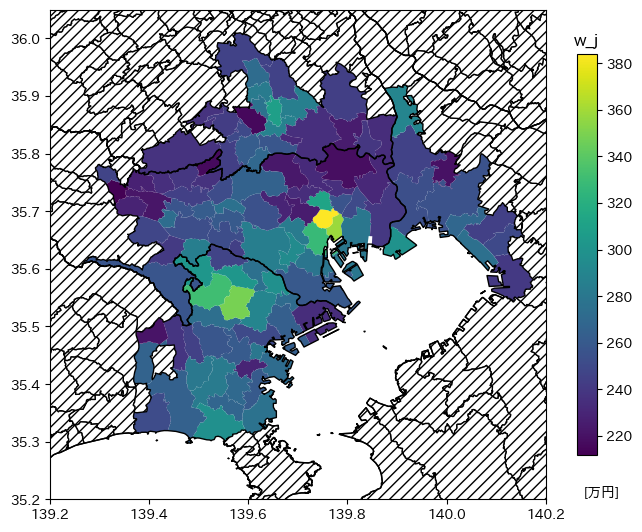

In [66]:
plot_gdf(gdf_vis, '2020', 'w_j', '[万円]', lambda x, pos: int(x))

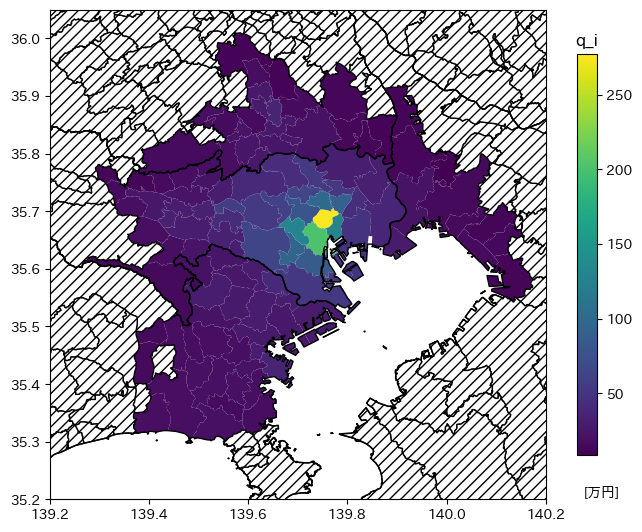

In [40]:
plot_gdf(gdf_vis, '2020', 'q_i', '[万円]', lambda x, pos: int(x*25))

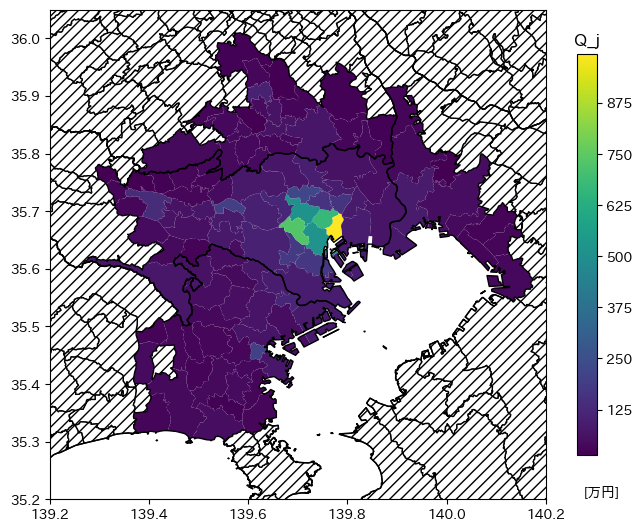

In [41]:
plot_gdf(gdf_vis, '2020', 'Q_j', '[万円]', lambda x, pos: int(x*25))

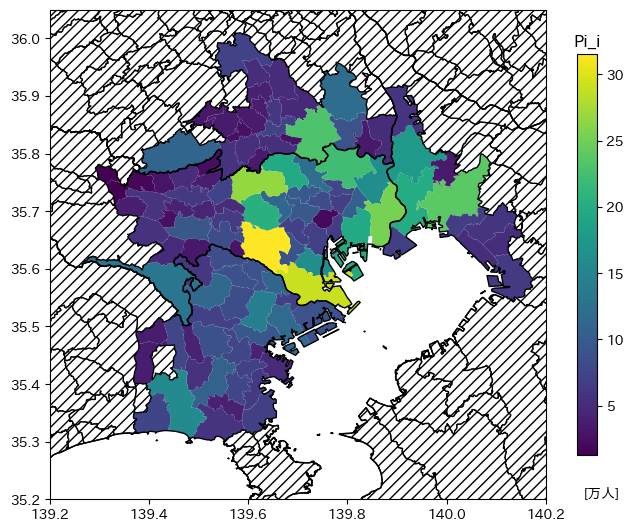

In [42]:
plot_gdf(gdf_vis, '2020', 'Pi_i', '[万人]', lambda x, pos: int(x/10000))

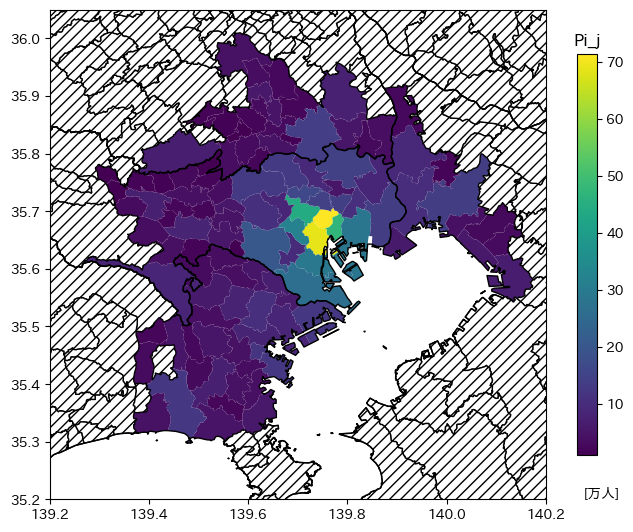

In [43]:
plot_gdf(gdf_vis, '2020', 'Pi_j', '[万人]', lambda x, pos: int(x/10000))

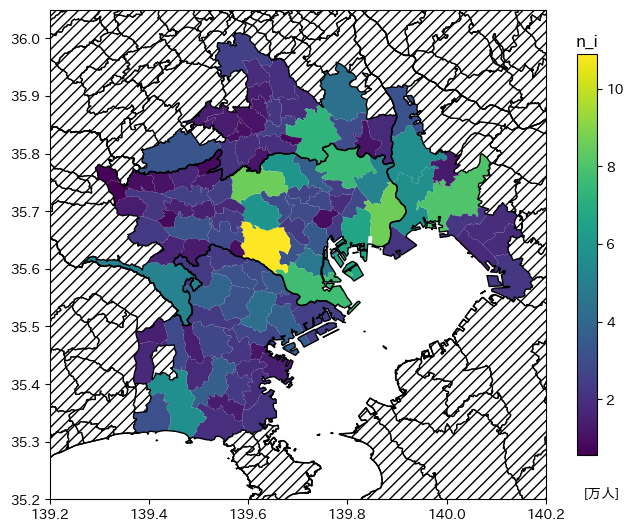

In [66]:
plot_gdf(gdf_vis, '2020', 'n_i', '[万人]', lambda x, pos: int(x/10000))

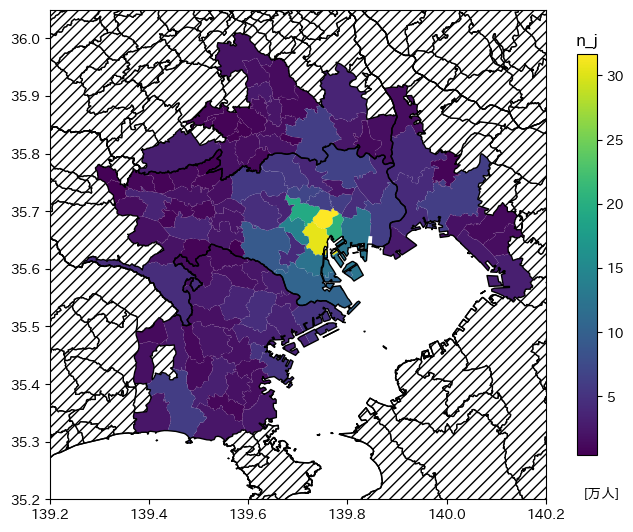

In [45]:
plot_gdf(gdf_vis, '2020', 'n_j', '[万人]', lambda x, pos: int(x/10000))

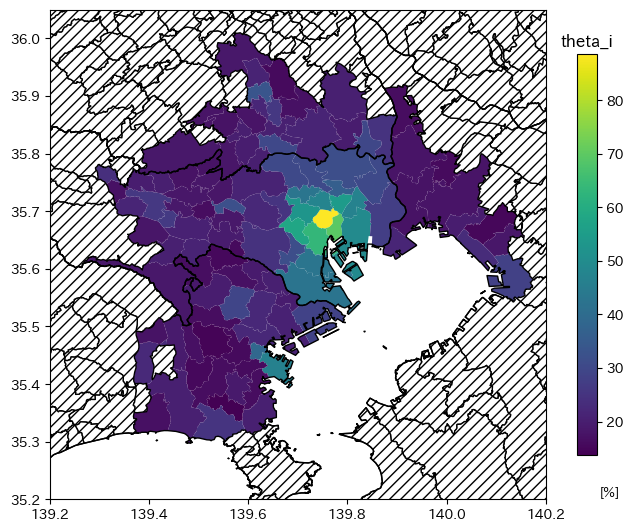

In [79]:
plot_gdf(gdf_vis, '2020', 'theta_i', '[%]', lambda x, pos: int(x*100))